<a href="https://colab.research.google.com/github/tqsyed/fc2conv-tf/blob/main/AutoDifferentiation_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Differentiation

> **Backpropagation** is the key algorithm that makes training deep models computationally tractable. For modern neural networks, it can make training with gradient descent as much as ten million times faster, relative to a naive implementation.

We have seen that in order to optimize our models we need to compute the derivative of the loss function with respect to all model paramaters.

The computation of derivatives in computer models is addressed by three main methods:

+ Manually working out derivatives and coding the result
+ Numerical differentiation (using finite difference approximations);
+ and Automatic differentiation (AD).

**Automatic differentiation** (AD) works by systematically applying the **chain rule** of differential calculus at the elementary operator level.

Let $ y = f(g(x)) $ our target function. In its basic form, the chain rule states:

$$ \frac{\partial f}{\partial x} = \frac{\partial f}{\partial g} \frac{\partial g}{\partial x} $$

or, if there are more than one variable $g_i$ in-between $y$ and $x$ (f.e. if $f$ is a two dimensional function such as $f(g_1(x), g_2(x))$), then:

$$ \frac{\partial f}{\partial x} = \sum_i \frac{\partial f}{\partial g_i} \frac{\partial g_i}{\partial x} $$

Now, let's see how AD allows the accurate evaluation of derivatives at machine precision, with only a small constant factor of overhead.

For example, let's consider the computation of the derivative of this function, that represents a 1-layer neural network model:

$$
    f(x) = \frac{1}{1 + e^{- ({w}^T \cdot  x + b)}}
$$


First, let's write how to evaluate $f(x)$ via a sequence of primitive operations:


```python
x = ?
f1 = w * x
f2 = f1 + b
f3 = -f2
f4 = 2.718281828459 ** f3
f5 = 1.0 + f4
f = 1.0/f5
```

The question mark indicates that $x$ is a value that must be provided.

This *program* can compute the value of $x$ and also **populate program variables**.

We can evaluate $\frac{\partial f}{\partial x}$ at some $x$ by using the chain rule. This is called *forward-mode differentiation*.

In our case:

In [ ]:
def f(x,w,b):
    f1 = w * x
    f2 = f1 + b
    f3 = -f2
    f4 = 2.718281828459 ** f3
    f5 = 1.0 + f4
    return 1.0/f5

def dfdx_forward(x, w, b):
    f1 = w * x
    p1 = w                            # p1 = df1/dx
    f2 = f1 + b
    p2 = p1 * 1.0                     # p2 = p1 * df2/df1
    f3 = -f2
    p3 = p2 * -1.0                    # p3 = p2 * df3/df2
    f4 = 2.718281828459 ** f3
    p4 = p3 * 2.718281828459 ** f3    # p4 = p3 * df4/df3
    f5 = 1.0 + f4
    p5 = p4 * 1.0                     # p5 = p4 * df5/df4
    f6 = 1.0/f5
    dfx = p5 * -1.0 / f5 ** 2.0        # df/dx = p5 * df6/df5
    return f6, dfx

der = (f(3+0.00001, 2, 1) - f(3, 2, 1))/0.00001

print("Value of the function at (3, 2, 1): ",f(3, 2, 1))
print("df/dx Derivative (finite diff) at (3, 2, 1): ",der)
print("df/dx Derivative (auto diff) at (3, 2, 1): ",dfdx_forward(3, 2, 1)[1])

Value of the function at (3, 2, 1):  0.9990889488055992
df/dx Derivative (finite diff) at (3, 2, 1):  0.0018204242002717306
df/dx Derivative (auto diff) at (3, 2, 1):  0.0018204423602438651


It is interesting to note that this *program* can be automatically derived  if we have access to **subroutines implementing the derivatives of primitive functions** (such as $\exp{(x)}$ or $1/x$) and all intermediate variables are computed in the right order.

It is also interesting to note that AD allows the accurate evaluation of derivatives at **machine precision**, with only a small constant factor of overhead.



## Autograd

Autograd is a Python module (with only one function) that implements automatic differentiation.

Autograd can automatically differentiate Python and Numpy code:

+ It can handle most of Python’s features, including loops, if statements, recursion and closures.
+ Autograd allows you to compute gradients of many types of data structures (Any nested combination of lists, tuples, arrays, or dicts).
+ It can also compute higher-order derivatives.
+ Uses reverse-mode differentiation (backpropagation) so it can efficiently take gradients of scalar-valued functions with respect to array-valued or vector-valued arguments.
+ You can easily implement your custim gradients (good for speed, numerical stability, non-compliant code, etc).

In [ ]:
import autograd.numpy as np
from autograd import grad

def f(x, w, b):
    f1 = w * x
    f2 = f1 + b
    f3 = -f2
    f4 = np.exp(f3)  # Using autograd's numpy for exponentiation
    f5 = 1.0 + f4
    return 1.0 / f5

# Use autograd to compute the gradient of f with respect to x, w, and b
grad_f = grad(f, argnum=(0, 1, 2))


x_val = 3.0
w_val = 2.0
b_val = 1.0


result = f(x_val, w_val, b_val)
gradients = grad_f(x_val, w_val, b_val)

# Print the results
print("Function value at ({}, {}, {}): {:.4f}".format(x_val, w_val, b_val, result))
print("Gradient with respect to x: ", gradients[0])
print("Gradient with respect to w: ", gradients[1])
print("Gradient with respect to b: ", gradients[2])


Function value at (3.0, 2.0, 1.0): 0.9991
Gradient with respect to x:  0.001820442360243653
Gradient with respect to w:  0.0027306635403654797
Gradient with respect to b:  0.0009102211801218265


Similarly, a simple (there is no bias term) logistic regression model for $n$-dimensional data like this

$$  f(x) = \frac{1}{1 + \exp^{-(\mathbf{w}^T \mathbf{x})}} $$

can be implemented in this way:

In [ ]:
import autograd.numpy as np
from autograd import grad

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logistic_predictions(weights, inputs):
    return sigmoid(np.dot(inputs, weights))

def training_loss(weights, inputs, targets):
    preds = logistic_predictions(weights, inputs)
    loss = preds * targets + (1 - preds) * (1 - targets)
    return -np.sum(np.log(loss))

def optimize(inputs, targets, training_loss):
    # Optimize weights using gradient descent.
    gradient_loss = grad(training_loss)
    weights = np.zeros(inputs.shape[1])
    print("Initial loss:", training_loss(weights, inputs, targets))
    for i in range(100):
        weights =  weight - gradient_loss(weights, inputs, targets) * 0.01
    print("Final loss:", training_loss(weights, inputs, targets))
    return weights

# Build a toy dataset with 3d data
inputs = np.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = np.array([True, True, False, True])

weights = optimize(inputs, targets, training_loss)
print("Weights:", weights)

Initial loss: 2.772588722239781
Final loss: 1.0672706757870165
Weights: [ 0.48307366 -0.37057217  1.06937395]


Any complex function that can be decomposed in a set of elementary functions can be derived in an automatic way, at machine precision, by this algorithm!

**We no longer need to code complex derivatives to apply SGD! **

## Neural Network

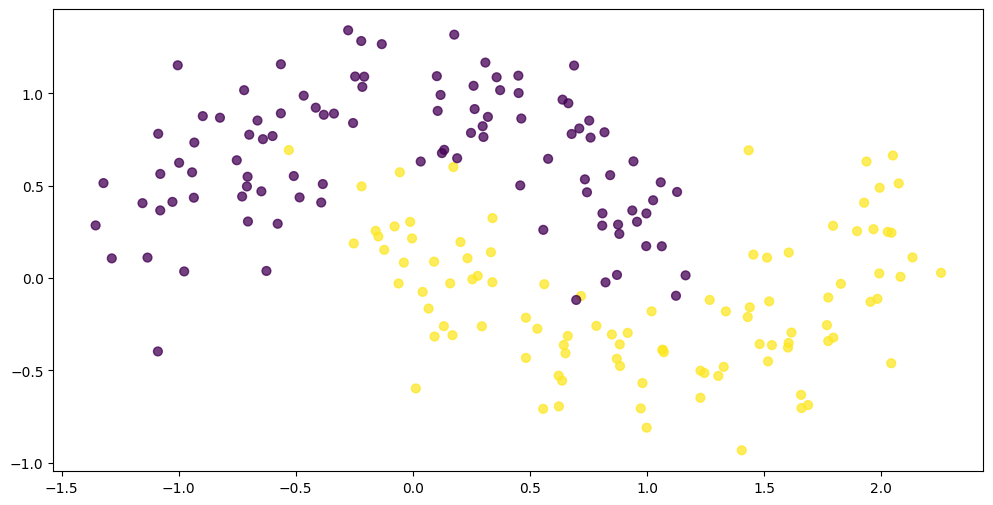

In [ ]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc.flatten import flatten

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.75)

Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2.

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function(s). If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \mbox{tanh}(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ a_2 = \mbox{softmax}({z_2})$$

$W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$.

A common choice with the softmax output is the **cross-entropy loss**. If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

In [ ]:
num_examples = len(X)     # training set size
nn_input_dim = 2          # input layer dimensionality
nn_output_dim = 2         # output layer dimensionality
epsilon = 0.01            # learning rate for gradient descent

def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation to calculate our predictions

    z1 = np.dot(X,W1) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calculating the loss

    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)

    return 1./num_examples * data_loss

# output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation

    z1 = np.dot(x,W1) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

This program solves the optimization problem by using AD:

Loss after iteration 0: 0.578567
Loss after iteration 1000: 0.288832
Loss after iteration 2000: 0.233156
Loss after iteration 3000: 0.182124
Loss after iteration 4000: 0.147160
Loss after iteration 5000: 0.118781
Loss after iteration 6000: 0.100822
Loss after iteration 7000: 0.089667
Loss after iteration 8000: 0.082638
Loss after iteration 9000: 0.078198
Loss after iteration 10000: 0.075316
Loss after iteration 11000: 0.073359
Loss after iteration 12000: 0.071963
Loss after iteration 13000: 0.070921
Loss after iteration 14000: 0.070112
Loss after iteration 15000: 0.069465
Loss after iteration 16000: 0.068932
Loss after iteration 17000: 0.068485
Loss after iteration 18000: 0.068102
Loss after iteration 19000: 0.067770


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

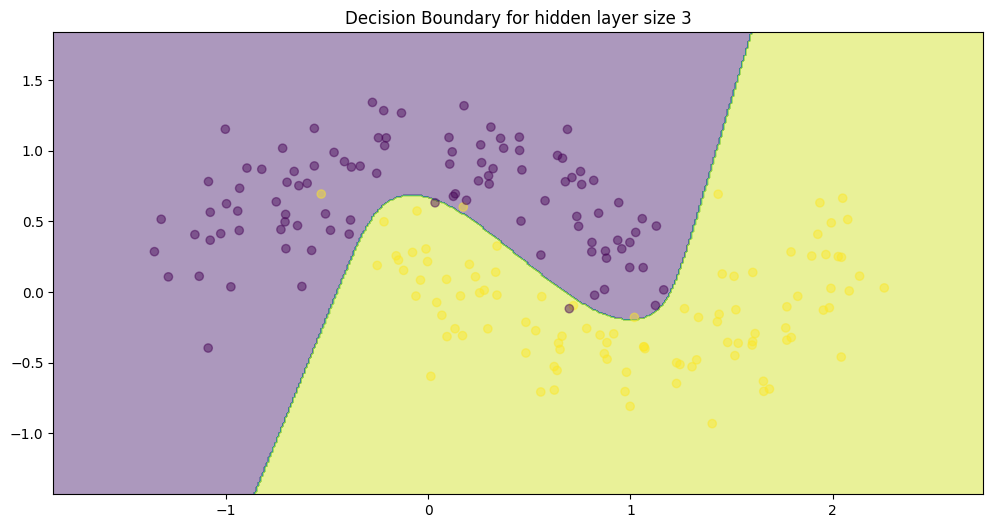

In [ ]:
# This function learns parameters for the neural network and returns the model.

def build_model(nn_hdim, num_passes=20000, print_loss=False):

    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = np.dot(X,model['W1']) + model['b1']
        a1 = np.tanh(z1)
        z2 = np.dot(a1,model['W2']) + model['b2']
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        gradient_loss = grad(calculate_loss)

        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        model_flat -= grad_flat * 0.05
        model = unflatten_m(model_flat)

        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))

    return model

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)



# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

Let's now get a sense of how varying the hidden layer size affects the result.

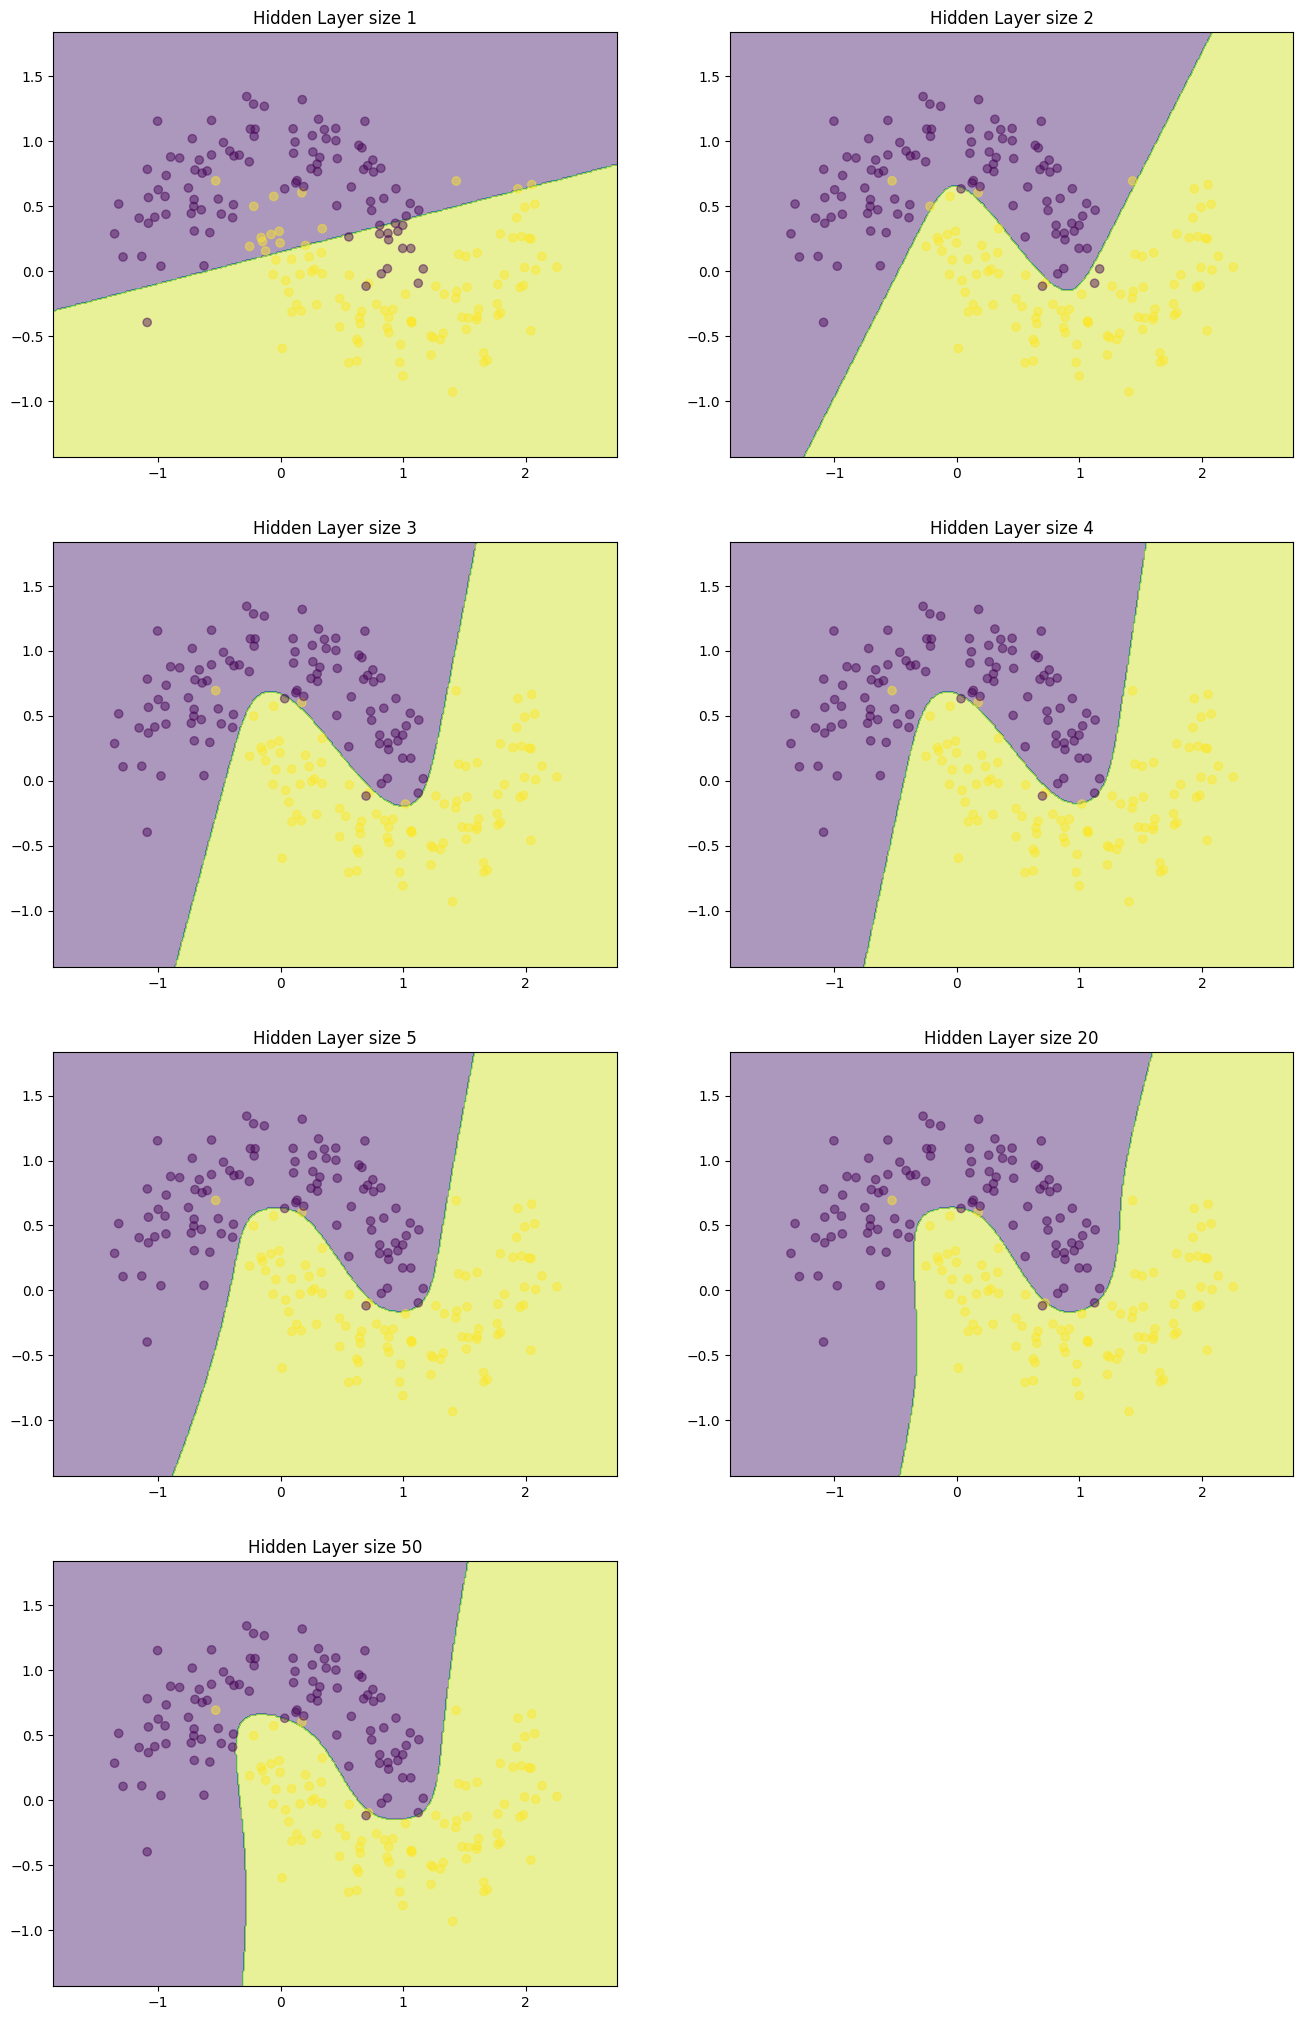

In [ ]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()